# Standardize and Statistically Test the Data

In [1]:
## Write the above description in more organized way, like
# No. of layers =  4
# Sequence length = 24, etc.

import torch
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import os
from scipy.stats import shapiro
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
# Set your working directory [Do not forget to make a short-cut of the folder shared by Galina to your Drive]
os.chdir('/content/drive/MyDrive/#WaterSoftHack25 - Water quality project/Project Codes/input datafiles/')

In [4]:
# import daily data
df = pd.read_csv('11447650_filled_daily_data.csv')

In [5]:
df.head()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
0,2009-12-03,25.0,562.0,8440.0,0.00,4.225000
1,2009-12-04,20.0,478.0,8650.0,0.00,4.405208
2,2009-12-05,14.0,334.0,8520.0,0.00,4.281053
3,2009-12-06,11.0,242.0,8250.0,0.13,4.666667
4,2009-12-07,21.0,507.0,9190.0,0.42,4.757317


In [6]:
df.tail()

,DATE,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu
5044,2023-09-25,16.0,806.0,18200.0,0.0,5.411458
5045,2023-09-26,15.0,698.0,17800.0,0.0,5.282292
5046,2023-09-27,13.0,619.0,17400.0,0.0,5.100000
5047,2023-09-28,13.0,582.0,17200.0,0.0,4.800000
5048,2023-09-29,12.0,559.0,17000.0,0.0,4.809375


Use MinMaxScaler to standardize data since it doesn’t reduce the effect of outliers, but rather linearly scales them down into a fixed range, where the largest occurring data point corresponds to the maximum value and the smallest one corresponds to the minimum value. This is important, since there are extreme water and sediment discharge values in the data

In [7]:
# Create a copy of the DataFrame
df_scaled = df.copy()

# Separate the DATE column
date_col = df_scaled['DATE']
df_to_scale = df_scaled.drop('DATE', axis=1)

# Initialize the MinMaxScaler
scaler_minmax = MinMaxScaler()

# Apply Min-Max normalization to the remaining columns
df_scaled_values = scaler_minmax.fit_transform(df_to_scale)

# Create a new DataFrame with the scaled values and the DATE column
df_scaled = pd.DataFrame(df_scaled_values, columns=df_to_scale.columns)
df_scaled['DATE'] = date_col

# Display the head of the new DataFrame
display(df_scaled.head())

,SSC_mg_L,SSD_st_d,Discharge_cfs,Precip_in,Turb_fnu,DATE
0,0.041308,0.010250,0.044633,0.000000,0.008162,2009-12-03
1,0.032702,0.008661,0.046919,0.000000,0.008562,2009-12-04
2,0.022375,0.005938,0.045504,0.000000,0.008286,2009-12-05
3,0.017212,0.004198,0.042565,0.024030,0.009144,2009-12-06
4,0.034423,0.009210,0.052798,0.077634,0.009345,2009-12-07


Shapiro-Wilk Test for Normality:
Variable: SSC_mg_L, Statistics=0.598, p=0.000
  (Reject the null hypothesis - does not look normally distributed)
Variable: SSD_st_d, Statistics=0.485, p=0.000
  (Reject the null hypothesis - does not look normally distributed)
Variable: Discharge_cfs, Statistics=0.706, p=0.000
  (Reject the null hypothesis - does not look normally distributed)
Variable: Precip_in, Statistics=0.250, p=0.000
  (Reject the null hypothesis - does not look normally distributed)
Variable: Turb_fnu, Statistics=0.453, p=0.000
  (Reject the null hypothesis - does not look normally distributed)


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 5049.
  res = hypotest_fun_out(*samples, **kwds)


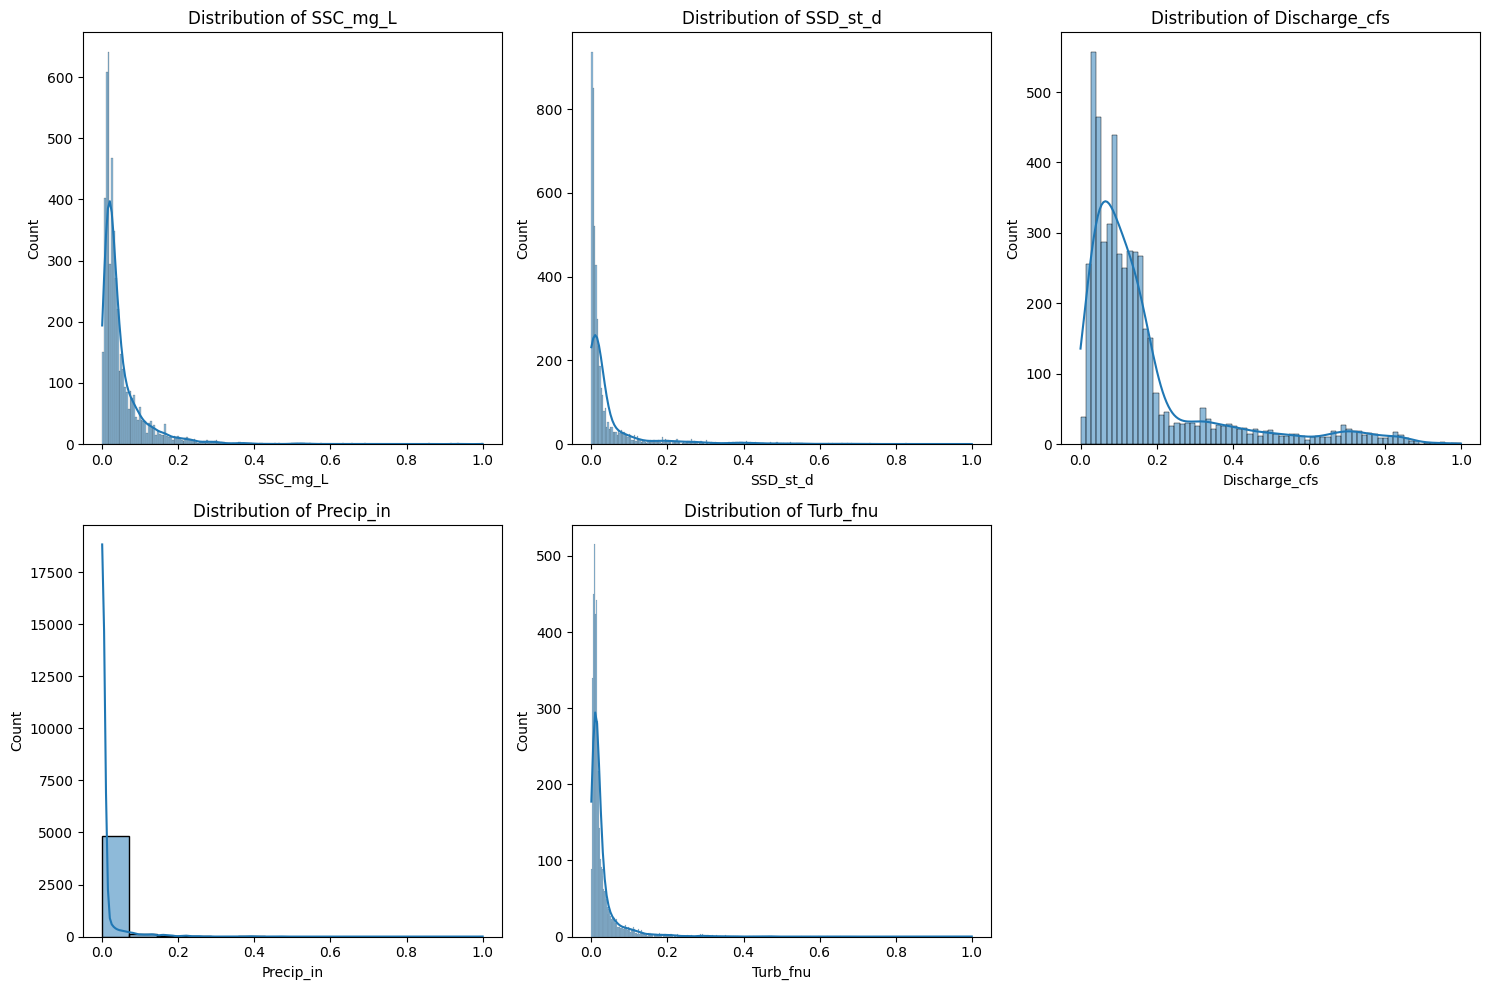

In [8]:
# Drop the 'DATE' column for normality check
df_for_normality = df_scaled.drop('DATE', axis=1)

# Perform Shapiro-Wilk test for each variable
print("Shapiro-Wilk Test for Normality:")
for column in df_for_normality.columns:
    stat, p = shapiro(df_for_normality[column])
    print(f"Variable: {column}, Statistics={stat:.3f}, p={p:.3f}")
    if p > 0.05:
        print("  (Fail to reject the null hypothesis - looks normally distributed)")
    else:
        print("  (Reject the null hypothesis - does not look normally distributed)")

# Visualize distributions with histograms
plt.figure(figsize=(15, 10))
for i, column in enumerate(df_for_normality.columns):
    plt.subplot(2, 3, i + 1)
    sns.histplot(df_for_normality[column], kde=True)
    plt.title(f'Distribution of {column}')
plt.tight_layout()
plt.show()

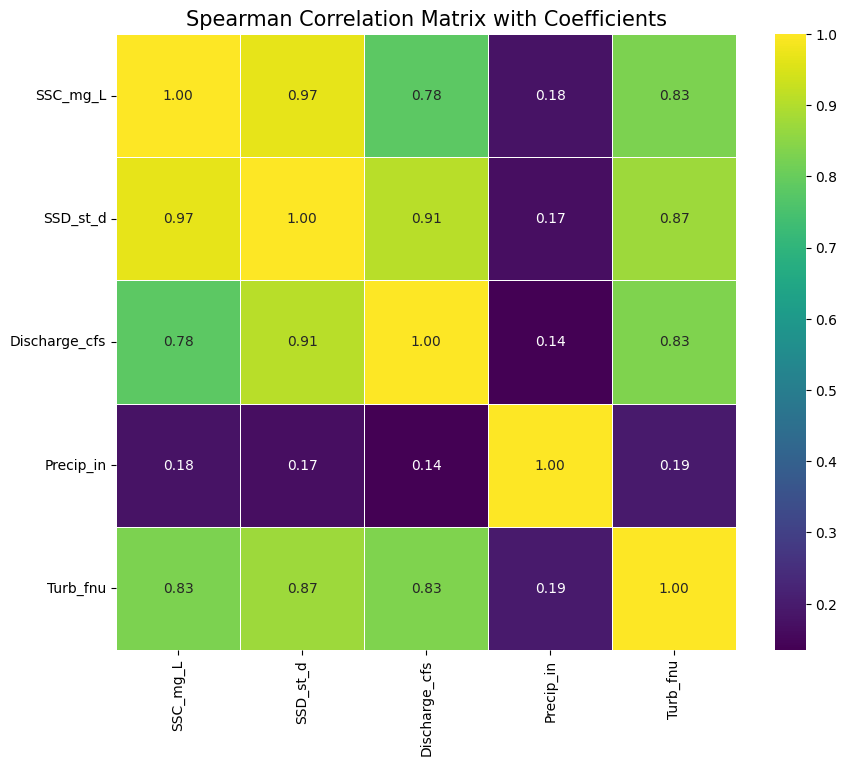

In [9]:
# Run Spearman Correlations and create the correlation matrix
corr_matrix = df_scaled.drop(['DATE'], axis=1).corr(method='spearman')

# Plot the correlation matrix as a heatmap with annotations
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, cmap='viridis', annot=True, fmt=".2f", linewidths=".5")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Spearman Correlation Matrix with Coefficients', fontsize=15)
plt.show()

# precip is not very well correlated with SSC (or discharge!)

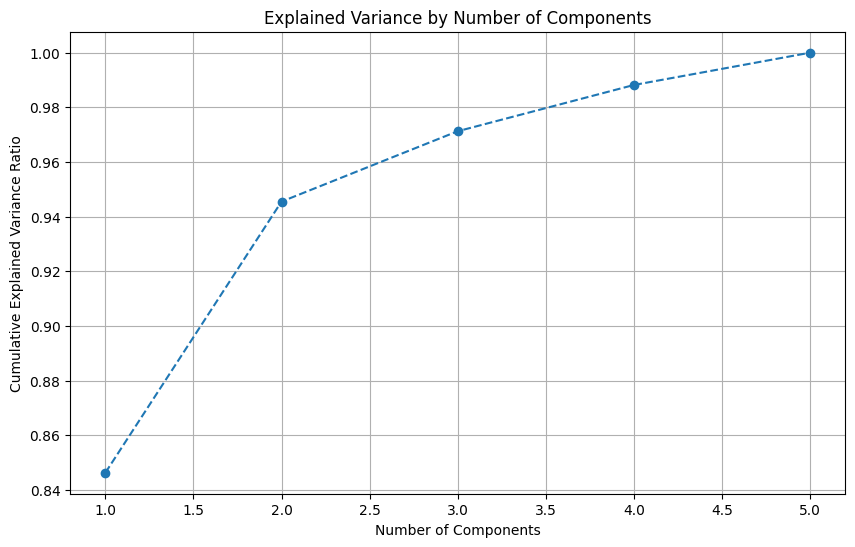

Explained variance ratio per component:
[0.84633748 0.09919155 0.02574228 0.01691472 0.01181396]


In [10]:
# Drop the 'DATE' column for PCA
df_pca = df_scaled.drop('DATE', axis=1)

# Initialize PCA
# We can choose the number of components or let PCA decide based on variance explained
pca = PCA()

# Fit PCA on the scaled data
pca.fit(df_pca)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Explained Variance by Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.grid(True)
plt.show()

# Print the explained variance ratio for each component
print("Explained variance ratio per component:")
print(pca.explained_variance_ratio_)

# You can also transform the data to the principal components
# df_pca_transformed = pca.transform(df_pca)
# df_pca_transformed = pd.DataFrame(df_pca_transformed, columns=[f'PC{i+1}' for i in range(df_pca_transformed.shape[1])])
# display(df_pca_transformed.head())

In [11]:
# Calculate the loadings (eigenvectors)
loadings = pca.components_

# Create a DataFrame for better visualization
loadings_df = pd.DataFrame(loadings.T, columns=[f'PC{i+1}' for i in range(loadings.shape[0])], index=df_pca.columns)

print("Principal Component Loadings:")
display(loadings_df)

Principal Component Loadings:


,PC1,PC2,PC3,PC4,PC5
SSC_mg_L,0.231872,0.577202,-0.061815,-0.261468,0.735450
SSD_st_d,0.454411,0.531452,-0.004424,-0.276760,-0.659131
Discharge_cfs,0.843925,-0.513024,-0.012590,0.042225,0.150517
Precip_in,0.031925,0.042028,0.997549,0.010838,0.044649
Turb_fnu,0.162841,0.345596,-0.029954,0.923655,0.003288


**Interpretation of PCA Results:**

The principal component loadings indicate the contribution of each original variable to the variance captured by the principal components.

*   **PC1:** Strongly influenced by `Discharge_cfs` and `SSD_st_d`, suggesting these variables capture the largest amount of shared variance in the dataset.
*   **PC2:** Shows strong contributions from `SSC_mg_L` and `SSD_st_d`.
*   **PC3:** Primarily driven by `Precip_in`.
*   **PC4:** Primarily driven by `Turb_fnu`.
*   **PC5:** Shows a strong positive relationship with `SSC_mg_L` and a strong negative relationship with `SSD_st_d`.

Overall, the PCA analysis highlights that `Discharge_cfs`, `SSD_st_d`, `Precip_in`, `Turb_fnu`, and `SSC_mg_L` are the most influential variables contributing to the overall variance in the dataset.

In [12]:
# as a result of the correlation and PCA tests, drop Precip_in
# also drop SSD_st_d since it is to similar to the target predicted variable and
# realistically would not be available at sites without SSC_mg_L anyway
df_final = df_scaled.drop(['Precip_in', 'SSD_st_d'], axis=1)
display(df_final.head())

,SSC_mg_L,Discharge_cfs,Turb_fnu,DATE
0,0.041308,0.044633,0.008162,2009-12-03
1,0.032702,0.046919,0.008562,2009-12-04
2,0.022375,0.045504,0.008286,2009-12-05
3,0.017212,0.042565,0.009144,2009-12-06
4,0.034423,0.052798,0.009345,2009-12-07


In [13]:
# write scaled data as CSV
#df_final.to_csv('11447650_filled_daily_data_MinMaxScaled_no_SSD_Precip.csv', index=False)

# Optimize Hyperparameters with Optuna

In [14]:
%pip install optuna plotly nbformat

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 7.5 MB/s eta 0:00:00


In [15]:
import optuna

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

# Implement determinism. Set a fixed value for random seed so that when the parameters are initialized, they are initialized same across all experiments.
torch.manual_seed(42)

# If you are using CUDA, also set the seed for it
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

# Set the seed for NumPy
np.random.seed(42)

Using device: cpu


Here we define **RiverData** a custom Dataset class to load the dataset we have. It extends the pytorch Dataset class.  
- We need to define \_\_init__() function which can be used for loading data from file and optionally for data preprocessing.
- Thereafter we define \_\_len__() function which gives the length of dataset.
- Then we define \_\_getitem__() function which returns an instance of (feature, label) tuple which can be used for model training.
  For our time series data, feature means the past values to be used for training and label means the future values to be predicted.

In [17]:
class RiverData(torch.utils.data.Dataset):

    def __init__(self, df, target, datecol, seq_len, pred_len):
        self.df = df
        self.datecol = datecol
        self.target = target
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.setIndex()


    def setIndex(self):
        self.df.set_index(self.datecol, inplace=True)


    def __len__(self):
        return len(self.df) - self.seq_len - self.pred_len


    def __getitem__(self, idx):
        if len(self.df) <= (idx + self.seq_len+self.pred_len):
            raise IndexError(f"Index {idx} is out of bounds for dataset of size {len(self.df)}")
        df_piece = self.df[idx:idx+self.seq_len].values
        feature = torch.tensor(df_piece, dtype=torch.float32)
        label_piece = self.df[self.target][idx + self.seq_len:  idx+self.seq_len+self.pred_len].values
        label = torch.tensor(label_piece, dtype=torch.float32)
        return (feature.T, label)

Some advanced python syntax have been used here. \
*common_args : it's used to pass arguments to a function, where common_args represents a python list \
**common_args: it's used to pass arguments to a function, where common_args represents a python dictionary

In [18]:
# Ratio for train:test:validation is 7:2:1
# we can vary it depending on the dataset

df = df_final
train_size = int(0.7 * len(df))
test_size = int(0.2 * len(df))
val_size = len(df) - train_size - test_size

seq_len = 14 # do one run with 7, one run with 14; time of concentration estimate is 0.48 days
pred_len = 1
num_features = df.shape[1] - 1 # number of variables (not including DATE)

common_args = ['SSC_mg_L', 'DATE', seq_len, pred_len]
train_dataset = RiverData(df[:train_size], *common_args)
val_dataset = RiverData(df[train_size: train_size+val_size], *common_args)
test_dataset = RiverData(df[train_size+val_size : len(df)], *common_args)


In [19]:
# Important parameters

BATCH_SIZE = 512 # keep as big as can be handled by GPU and memory
SHUFFLE = False # we don't shuffle the time series data
DATA_LOAD_WORKERS = 1 # it depends on amount of data you need to load


In [20]:
from torch.utils.data import DataLoader

common_args = {'batch_size': BATCH_SIZE, 'shuffle': SHUFFLE}
train_loader = DataLoader(train_dataset, **common_args)
val_loader = DataLoader(val_dataset, **common_args)
test_loader = DataLoader(test_dataset, **common_args)

### Here we define our pytorch model.

BasicMLPNetwork is the model class, it extends the Module class provided by pytorch. \
- We define \_\_init__() function. It sets up layers and defines the model parameters.
- Also, we define forward() function which defines how the forward pass computation occurs

In [21]:
# Here we are adding dropout layers.

class BasicMLPNetwork(torch.nn.Module):

    def __init__(self, seq_len, pred_len, num_features, dropout):
        # call the constructor of the base class
        super().__init__()
        self.seq_len = seq_len
        self.pred_len = pred_len
        self.num_features = num_features
        hidden_size_time = 256
        hidden_size_feat = 128
        # define layers for combining across time series
        self.fc1 = torch.nn.Linear(self.seq_len, hidden_size_time)
        self.relu = torch.nn.ReLU()
        self.dropout1 = torch.nn.Dropout(p=dropout)
        self.fc2 = torch.nn.Linear(hidden_size_time, self.pred_len)
        self.dropout2 = torch.nn.Dropout(p=dropout)

        # define layers for combining across the features
        self.fc3 = torch.nn.Linear(self.num_features, hidden_size_feat)
        self.fc4 = torch.nn.Linear(hidden_size_feat, 1)

    def forward(self, x):

        # computation over time
        out = self.fc1(x)
        out = self.relu(out)
        out = self.dropout1(out)
        out = self.fc2(out)
        out = self.relu(out) # has dimension 512 x 7 x 12
        out = self.dropout2(out)
        # computation over features
        out = out.transpose(1,2) # dimension 512 x 12 x 7
        out = self.fc3(out) # dimension 512 x 12 x 20
        out = self.relu(out)
        out = self.fc4(out) # dimension 512 x 12 x 1

        out = out.squeeze(-1) # dimension 512 x 12

        return out

# Note that the gradients are stored insize the FC layer objects
# For each training example we need to get rid of these gradients

In [22]:
loss = torch.nn.MSELoss()

In [23]:
for i, (f,l) in enumerate(train_loader):
    print('features shape: ', f.shape)
    print('labels shape: ', l.shape)
    break

features shape:  torch.Size([512, 3, 14])
labels shape:  torch.Size([512, 1])


In [24]:
# define metrics
import numpy as np
epsilon = np.finfo(float).eps

def Wape(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader):
    # following line prepares the model for evaulation mode. It disables dropout and batch normalization if they have
    # are part of the model. For our simple model it's not necessary. Still I'm going to use it.

    model.eval()
    all_inputs = torch.empty((0, num_features, seq_len))
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        all_inputs = torch.vstack((all_inputs, inputs))
        all_labels = torch.vstack((all_labels, labels))

    with torch.no_grad():
        all_inputs = all_inputs.to(device)
        outputs = model(all_inputs).detach().cpu()
        avg_val_loss = loss(outputs, all_labels)
        nsee = nse(all_labels.numpy(), outputs.numpy())
        wapee = Wape(all_labels.numpy(), outputs.numpy())

    print(f'NSE : {nsee}', end=' ')
    print(f'WAPE : {wapee}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')
    model.train()
    return avg_val_loss


In [25]:
def objective(trial):
    # Here we define the search space of the hyper-parameters. Optuna uses byaesian optimization to find the optimal values of the hyperparameters.
    # set initial values of hyperparameter ranges based on this information:  https://copilot.microsoft.com/shares/bLecE7xyBTUfFYaoUTGmu
    learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
    dropout_p = trial.suggest_uniform('dropout_p', 0.05, 0.3)

    model = BasicMLPNetwork(seq_len, pred_len, num_features, dropout_p)
    model = model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)

    num_epochs = 300
    best_val_loss = float('inf')
    patience = 10

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = []
        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs).unsqueeze(1) # Add unsqueeze(1) here
            loss_val = loss(outputs, labels)

            # calculate gradients for back propagation
            loss_val.backward()

            # update the weights based on the gradients
            optimizer.step()

            # reset the gradients, avoid gradient accumulation
            optimizer.zero_grad()
            epoch_loss.append(loss_val.item())

        avg_train_loss = sum(epoch_loss)/len(epoch_loss)
        print(f'Epoch {epoch+1}: Traning Loss: {avg_train_loss}', end=' ')
        avg_val_loss = evaluate_model(model, val_loader)

        # Check for improvement
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_no_improve = 0
            # Save the best model
            torch.save(model.state_dict(), 'best_model_trial.pth')
        else:
            epochs_no_improve += 1
            if epochs_no_improve == patience:
                print('Early stopping!')
                # Load the best model before stopping
                model.load_state_dict(torch.load('best_model_trial.pth'))
                break

        # Report intermediate objective value
        trial.report(best_val_loss, epoch)

        # Handle pruning based on the intermediate value
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_loss

study = optuna.create_study(direction='minimize')

# normally you run 100s of trials.
study.optimize(objective, n_trials=200)

print('Number of finished trials:', len(study.trials))
print('Best trial:')
trial = study.best_trial

print('  Value (Best Validation Loss):', trial.value)
print('  Params:')
for key, value in trial.params.items():
    print(f'    {key}: {value}')

[I 2025-08-08 04:33:45,341] A new study created in memory with name: no-name-96f30f60-4358-4841-a0b9-b014f5964219
/tmp/ipython-input-540428140.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-540428140.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
/tmp/ipython-input-540428140.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_p = trial.suggest_uniform('dropout_p', 0.05

Epoch 1: Traning Loss: 0.008397570478596858 NSE : -0.2222883701324463 WAPE : 45.70804120037048 Validation Loss: 0.00026487253489904106
Epoch 2: Traning Loss: 0.006393657864204475 NSE : -6.455743312835693 WAPE : 165.37220012281978 Validation Loss: 0.0016156758647412062
Epoch 3: Traning Loss: 0.005758092006934541 NSE : -13.386893272399902 WAPE : 233.2620381376499 Validation Loss: 0.003117671236395836
Epoch 4: Traning Loss: 0.005545397422143391 NSE : -2.5372323989868164 WAPE : 111.19939170200152 Validation Loss: 0.0007665259181521833
Epoch 5: Traning Loss: 0.005525796175269144 NSE : -5.243320465087891 WAPE : 150.734599071722 Validation Loss: 0.0013529410352930427
Epoch 6: Traning Loss: 0.005454734001042587 NSE : -8.081866264343262 WAPE : 183.33340716672603 Validation Loss: 0.001968060154467821
Epoch 7: Traning Loss: 0.0054418417691652265 NSE : -4.369606971740723 WAPE : 139.24946378150287 Validation Loss: 0.0011636054841801524
Epoch 8: Traning Loss: 0.005429520637595228 NSE : -5.8968801498

[I 2025-08-08 04:34:17,207] Trial 0 finished with value: 0.00026487253489904106 and parameters: {'lr': 0.001360498328245409, 'weight_decay': 0.00010774437655369696, 'dropout_p': 0.07447576911620891}. Best is trial 0 with value: 0.00026487253489904106.


Epoch 11: Traning Loss: 0.005423139414883086 NSE : -6.020853519439697 WAPE : 160.2466358511161 Validation Loss: 0.0015214341692626476
Early stopping!


/tmp/ipython-input-540428140.py:4: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform('lr', 1e-4, 1e-2)
/tmp/ipython-input-540428140.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-5, 1e-2)
/tmp/ipython-input-540428140.py:6: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_p = trial.suggest_uniform('dropout_p', 0.05, 0.3)


Epoch 1: Traning Loss: 0.025933129380324056 NSE : -0.41689109802246094 WAPE : 63.35788586187767 Validation Loss: 0.0003070433740504086
Epoch 2: Traning Loss: 0.010832253377884626 NSE : -0.8359922170639038 WAPE : 75.68208054365003 Validation Loss: 0.0003978635068051517
Epoch 3: Traning Loss: 0.007842238160914608 NSE : -16.67230224609375 WAPE : 259.59755674437537 Validation Loss: 0.0038296268321573734
Epoch 4: Traning Loss: 0.006825832816373024 NSE : -0.2555652856826782 WAPE : 57.86324378401543 Validation Loss: 0.00027208373649045825
Epoch 5: Traning Loss: 0.00594653155920761 NSE : -16.299150466918945 WAPE : 256.74578792335893 Validation Loss: 0.0037487628869712353
Epoch 6: Traning Loss: 0.005840061432016748 NSE : -1.8104238510131836 WAPE : 97.7187404112364 Validation Loss: 0.0006090249517001212
Epoch 7: Traning Loss: 0.005566866270133427 NSE : -6.893295764923096 WAPE : 170.38778328723484 Validation Loss: 0.001710494514554739
Epoch 8: Traning Loss: 0.005467412727219718 NSE : -5.784367084

[I 2025-08-08 04:34:25,446] Trial 1 finished with value: 0.00027208373649045825 and parameters: {'lr': 0.009213696883996857, 'weight_decay': 0.0009475915255823028, 'dropout_p': 0.1967348367766572}. Best is trial 0 with value: 0.00026487253489904106.


Epoch 14: Traning Loss: 0.005460388625838927 NSE : -5.152618885040283 WAPE : 149.58737860223025 Validation Loss: 0.0013332857051864266
Early stopping!
Epoch 1: Traning Loss: 0.044634620526007245 NSE : -105.83861541748047 WAPE : 652.0515221116106 Validation Loss: 0.023152155801653862
Epoch 2: Traning Loss: 0.03598819140877042 NSE : -75.31612396240234 WAPE : 550.2194816009833 Validation Loss: 0.016537869349122047
Epoch 3: Traning Loss: 0.028314957661288127 NSE : -50.421024322509766 WAPE : 450.3350043919724 Validation Loss: 0.011143048293888569
Epoch 4: Traning Loss: 0.02195392070072038 NSE : -31.750598907470703 WAPE : 357.44999967819786 Validation Loss: 0.007097125984728336
Epoch 5: Traning Loss: 0.017034024665398256 NSE : -18.475175857543945 WAPE : 272.9391059233076 Validation Loss: 0.004220312926918268
Epoch 6: Traning Loss: 0.013130176413272108 NSE : -9.392953872680664 WAPE : 195.29973278720027 Validation Loss: 0.002252175472676754
Epoch 7: Traning Loss: 0.01026690106040665 NSE : -3.6

[I 2025-08-08 04:34:36,918] Trial 2 finished with value: 0.00018338226072955877 and parameters: {'lr': 0.00011569013431405158, 'weight_decay': 0.00046373099526702996, 'dropout_p': 0.0774605485101753}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 19: Traning Loss: 0.005811344100428479 NSE : -2.8998355865478516 WAPE : 118.44349233730583 Validation Loss: 0.0008451028261333704
Early stopping!
Epoch 1: Traning Loss: 0.006153481912666133 NSE : -0.7827508449554443 WAPE : 74.21969457549407 Validation Loss: 0.00038632602081634104
Epoch 2: Traning Loss: 0.005607341482703175 NSE : -10.558727264404297 WAPE : 208.04035616225613 Validation Loss: 0.0025048013776540756
Epoch 3: Traning Loss: 0.005531540107248085 NSE : -3.2542476654052734 WAPE : 122.96703584198863 Validation Loss: 0.0009219046332873404
Epoch 4: Traning Loss: 0.005480749499318855 NSE : -6.872284412384033 WAPE : 170.15061928524315 Validation Loss: 0.0017059409292414784
Epoch 5: Traning Loss: 0.005453530665753143 NSE : -4.996047496795654 WAPE : 147.58304438704758 Validation Loss: 0.0012993566924706101
Epoch 6: Traning Loss: 0.005461985544700708 NSE : -5.430999279022217 WAPE : 153.0772852570401 Validation Loss: 0.0013936114264652133
Epoch 7: Traning Loss: 0.00544098169276756

[I 2025-08-08 04:34:42,890] Trial 3 finished with value: 0.00038632602081634104 and parameters: {'lr': 0.002132965876808443, 'weight_decay': 0.0009715675611107811, 'dropout_p': 0.054448319526613595}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005446020779865128 NSE : -5.603528022766113 WAPE : 155.19539533727914 Validation Loss: 0.0014309987891465425
Early stopping!
Epoch 1: Traning Loss: 0.012000154171671187 NSE : -0.1287858486175537 WAPE : 52.77918363058518 Validation Loss: 0.0002446103317197412
Epoch 2: Traning Loss: 0.006404698194403734 NSE : -0.44403088092803955 WAPE : 64.27329594688945 Validation Loss: 0.000312924588797614
Epoch 3: Traning Loss: 0.0057933347831879345 NSE : -12.769968032836914 WAPE : 227.9683176175474 Validation Loss: 0.002983981976285577
Epoch 4: Traning Loss: 0.005613265758646386 NSE : -6.257245063781738 WAPE : 163.04720051775877 Validation Loss: 0.0015726607525721192
Epoch 5: Traning Loss: 0.005668094714305231 NSE : -2.441652297973633 WAPE : 109.53498085444404 Validation Loss: 0.0007458135369233787
Epoch 6: Traning Loss: 0.00554244895465672 NSE : -5.073808670043945 WAPE : 148.58235288856713 Validation Loss: 0.0013162074610590935
Epoch 7: Traning Loss: 0.005468031990208796 NS

[I 2025-08-08 04:34:49,910] Trial 4 finished with value: 0.0002446103317197412 and parameters: {'lr': 0.00833408897154153, 'weight_decay': 0.0012078735486679773, 'dropout_p': 0.2720975197341281}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005490138993731567 NSE : -5.161643981933594 WAPE : 149.70199031701523 Validation Loss: 0.001335241599008441
Early stopping!


[I 2025-08-08 04:34:50,460] Trial 5 pruned. 


Epoch 1: Traning Loss: 0.007993134570174984 NSE : -3.6047239303588867 WAPE : 128.30191360272713 Validation Loss: 0.0009978535817936063


[I 2025-08-08 04:34:50,986] Trial 6 pruned. 


Epoch 1: Traning Loss: 0.027741345443895886 NSE : -7.004324913024902 WAPE : 167.08343527217315 Validation Loss: 0.001734554418362677


[I 2025-08-08 04:34:51,547] Trial 7 pruned. 


Epoch 1: Traning Loss: 0.021635109425655434 NSE : -14.637701988220215 WAPE : 240.80783873249075 Validation Loss: 0.0033887240570038557


[I 2025-08-08 04:34:52,081] Trial 8 pruned. 


Epoch 1: Traning Loss: 0.013141257821449212 NSE : -17.469844818115234 WAPE : 265.59507945294973 Validation Loss: 0.004002455621957779


[I 2025-08-08 04:34:52,821] Trial 9 pruned. 


Epoch 1: Traning Loss: 0.011408635747752019 NSE : -4.4262003898620605 WAPE : 133.00142855077115 Validation Loss: 0.0011758693726733327


[I 2025-08-08 04:34:53,392] Trial 10 pruned. 


Epoch 1: Traning Loss: 0.059024774602481296 NSE : -152.74989318847656 WAPE : 782.9320154100599 Validation Loss: 0.033317938446998596


[I 2025-08-08 04:34:53,944] Trial 11 pruned. 


Epoch 1: Traning Loss: 0.0732330179640225 NSE : -212.67234802246094 WAPE : 923.8400307325229 Validation Loss: 0.046303264796733856


[I 2025-08-08 04:34:54,517] Trial 12 pruned. 


Epoch 1: Traning Loss: 0.010910669541252511 NSE : -1.0260734558105469 WAPE : 81.15513262302267 Validation Loss: 0.0004390545072965324


[I 2025-08-08 04:34:55,063] Trial 13 pruned. 


Epoch 1: Traning Loss: 0.0056912928620087245 NSE : -10.357099533081055 WAPE : 206.1298042866219 Validation Loss: 0.002461108146235347


[I 2025-08-08 04:34:55,615] Trial 14 pruned. 


Epoch 1: Traning Loss: 0.04243557022086212 NSE : -31.71627426147461 WAPE : 356.7650709765976 Validation Loss: 0.00708968797698617


[I 2025-08-08 04:34:56,168] Trial 15 pruned. 


Epoch 1: Traning Loss: 0.006712680416447776 NSE : -13.372196197509766 WAPE : 233.13734607513803 Validation Loss: 0.0031144856475293636


[I 2025-08-08 04:34:56,717] Trial 16 pruned. 


Epoch 1: Traning Loss: 0.023763216765863553 NSE : -28.006900787353516 WAPE : 335.2538429654009 Validation Loss: 0.006285857874900103


[I 2025-08-08 04:34:57,275] Trial 17 pruned. 


Epoch 1: Traning Loss: 0.012467754073441029 NSE : -10.997624397277832 WAPE : 212.13705628603714 Validation Loss: 0.0025999112986028194


[I 2025-08-08 04:34:57,936] Trial 18 pruned. 


Epoch 1: Traning Loss: 0.008322093236659254 NSE : -15.913335800170898 WAPE : 253.76270710998017 Validation Loss: 0.003665156429633498


[I 2025-08-08 04:34:58,732] Trial 19 pruned. 


Epoch 1: Traning Loss: 0.0190374517946371 NSE : -25.863203048706055 WAPE : 322.22862947475284 Validation Loss: 0.005821314640343189


[I 2025-08-08 04:34:59,572] Trial 20 pruned. 


Epoch 1: Traning Loss: 0.010376476815768651 NSE : -20.324121475219727 WAPE : 286.1007969576407 Validation Loss: 0.004620983265340328


[I 2025-08-08 04:35:00,317] Trial 21 pruned. 


Epoch 1: Traning Loss: 0.015309131837316923 NSE : -40.53398895263672 WAPE : 404.480756357076 Validation Loss: 0.0090005062520504
Epoch 1: Traning Loss: 0.008843029549877559 NSE : -0.026673436164855957 WAPE : 43.74120320401261 Validation Loss: 0.00022248235472943634
Epoch 2: Traning Loss: 0.006890723016113043 NSE : -1.6208081245422363 WAPE : 93.87764313445989 Validation Loss: 0.0005679348250851035
Epoch 3: Traning Loss: 0.0056178269109555656 NSE : -15.962533950805664 WAPE : 254.14509164381803 Validation Loss: 0.0036758172791451216
Epoch 4: Traning Loss: 0.005745276010462216 NSE : -5.760178089141846 WAPE : 157.09389425982707 Validation Loss: 0.001464945380575955
Epoch 5: Traning Loss: 0.005511813364656908 NSE : -2.6388871669769287 WAPE : 112.94823173064441 Validation Loss: 0.0007885547820478678
Epoch 6: Traning Loss: 0.005452163118336882 NSE : -7.649750709533691 WAPE : 178.71117488458796 Validation Loss: 0.0018744196277111769
Epoch 7: Traning Loss: 0.00546388141810894 NSE : -6.5436363220

[I 2025-08-08 04:35:06,709] Trial 22 finished with value: 0.00022248235472943634 and parameters: {'lr': 0.0012768610430569675, 'weight_decay': 7.231332752456809e-05, 'dropout_p': 0.08756140049312418}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005422856259558882 NSE : -5.2851972579956055 WAPE : 151.2609002118294 Validation Loss: 0.0013620159588754177
Early stopping!


[I 2025-08-08 04:35:07,309] Trial 23 pruned. 


Epoch 1: Traning Loss: 0.005599606516105788 NSE : -5.230338096618652 WAPE : 150.46266372102076 Validation Loss: 0.0013501278590410948


[I 2025-08-08 04:35:07,847] Trial 24 pruned. 


Epoch 1: Traning Loss: 0.00782463762776128 NSE : -1.9333643913269043 WAPE : 100.881378463312 Validation Loss: 0.0006356664234772325


[I 2025-08-08 04:35:08,419] Trial 25 pruned. 


Epoch 1: Traning Loss: 0.009758109559438058 NSE : -3.9267964363098145 WAPE : 133.021505661252 Validation Loss: 0.0010676474776118994


[I 2025-08-08 04:35:08,962] Trial 26 pruned. 


Epoch 1: Traning Loss: 0.008165029808878899 NSE : -2.623796224594116 WAPE : 112.6907482217506 Validation Loss: 0.0007852844428271055


[I 2025-08-08 04:35:09,576] Trial 27 pruned. 


Epoch 1: Traning Loss: 0.009831586686362113 NSE : -12.152093887329102 WAPE : 222.49763099290672 Validation Loss: 0.002850087359547615


[I 2025-08-08 04:35:10,191] Trial 28 pruned. 


Epoch 1: Traning Loss: 0.00603128201328218 NSE : -6.109778881072998 WAPE : 161.30649330697509 Validation Loss: 0.001540704513899982


[I 2025-08-08 04:35:10,734] Trial 29 pruned. 


Epoch 1: Traning Loss: 0.006262058891089899 NSE : -1.1203274726867676 WAPE : 84.45273533077457 Validation Loss: 0.00045947954640723765


[I 2025-08-08 04:35:11,320] Trial 30 pruned. 


Epoch 1: Traning Loss: 0.03718623412506921 NSE : -42.342105865478516 WAPE : 412.21848476659693 Validation Loss: 0.009392328560352325


[I 2025-08-08 04:35:12,067] Trial 31 pruned. 


Epoch 1: Traning Loss: 0.007854946223752839 NSE : -18.71427345275879 WAPE : 274.7124112735065 Validation Loss: 0.004272125661373138


[I 2025-08-08 04:35:12,861] Trial 32 pruned. 


Epoch 1: Traning Loss: 0.016026568000337908 NSE : -1.3161392211914062 WAPE : 72.76872631463073 Validation Loss: 0.0005019123782403767


[I 2025-08-08 04:35:13,668] Trial 33 pruned. 


Epoch 1: Traning Loss: 0.016299860485430275 NSE : -4.65023136138916 WAPE : 132.85876571909446 Validation Loss: 0.001224417588673532


[I 2025-08-08 04:35:14,445] Trial 34 pruned. 


Epoch 1: Traning Loss: 0.032220425084233284 NSE : -6.73480224609375 WAPE : 164.40070870026787 Validation Loss: 0.0016761482693254948


[I 2025-08-08 04:35:15,317] Trial 35 pruned. 


Epoch 1: Traning Loss: 0.0059004344844392365 NSE : -5.873733997344971 WAPE : 158.47587148409215 Validation Loss: 0.001489552902057767


[I 2025-08-08 04:35:15,885] Trial 36 pruned. 


Epoch 1: Traning Loss: 0.006129267226372447 NSE : -1.2464234828948975 WAPE : 85.18564180679617 Validation Loss: 0.00048680484178476036


[I 2025-08-08 04:35:16,438] Trial 37 pruned. 


Epoch 1: Traning Loss: 0.02920916024595499 NSE : -138.5977020263672 WAPE : 745.7946101567611 Validation Loss: 0.030251121148467064


[I 2025-08-08 04:35:17,012] Trial 38 pruned. 


Epoch 1: Traning Loss: 0.008128459897956677 NSE : -13.943451881408691 WAPE : 237.93646087684147 Validation Loss: 0.003238278441131115


[I 2025-08-08 04:35:17,564] Trial 39 pruned. 


Epoch 1: Traning Loss: 0.024257554539612362 NSE : -0.3603173494338989 WAPE : 61.546699801978846 Validation Loss: 0.00029478376382030547


[I 2025-08-08 04:35:18,132] Trial 40 pruned. 


Epoch 1: Traning Loss: 0.01588252027119909 NSE : -75.97992706298828 WAPE : 552.1927222062621 Validation Loss: 0.016681717708706856


[I 2025-08-08 04:35:18,895] Trial 41 pruned. 


Epoch 1: Traning Loss: 0.008713273431307502 NSE : -2.493438720703125 WAPE : 110.4351910121413 Validation Loss: 0.0007570357993245125


[I 2025-08-08 04:35:19,448] Trial 42 pruned. 


Epoch 1: Traning Loss: 0.00858899305707642 NSE : -1.125002384185791 WAPE : 82.96505654983132 Validation Loss: 0.0004604926216416061


[I 2025-08-08 04:35:20,004] Trial 43 pruned. 


Epoch 1: Traning Loss: 0.013134359116000789 NSE : -2.5580763816833496 WAPE : 111.56080476614889 Validation Loss: 0.0007710428908467293


[I 2025-08-08 04:35:20,552] Trial 44 pruned. 


Epoch 1: Traning Loss: 0.006277942464553884 NSE : -6.022994518280029 WAPE : 160.27224628680028 Validation Loss: 0.0015218983171507716


[I 2025-08-08 04:35:21,125] Trial 45 pruned. 


Epoch 1: Traning Loss: 0.016024010089625205 NSE : -3.431192398071289 WAPE : 117.34477622756442 Validation Loss: 0.0009602491627447307


[I 2025-08-08 04:35:21,669] Trial 46 pruned. 


Epoch 1: Traning Loss: 0.005779645239402141 NSE : -4.398953437805176 WAPE : 140.13283156716895 Validation Loss: 0.0011699649039655924


[I 2025-08-08 04:35:22,251] Trial 47 pruned. 


Epoch 1: Traning Loss: 0.007337266579270363 NSE : -14.07431411743164 WAPE : 239.01886955837796 Validation Loss: 0.0032666365150362253


[I 2025-08-08 04:35:22,782] Trial 48 pruned. 


Epoch 1: Traning Loss: 0.02680836178894554 NSE : -4.2592902183532715 WAPE : 137.7247819330747 Validation Loss: 0.0011396995978429914


[I 2025-08-08 04:35:23,346] Trial 49 pruned. 


Epoch 1: Traning Loss: 0.005495358291747314 NSE : -7.636098861694336 WAPE : 178.56301216169715 Validation Loss: 0.0018714609323069453
Epoch 1: Traning Loss: 0.01748931161793215 NSE : -0.19981026649475098 WAPE : 50.26331356075077 Validation Loss: 0.0002600015141069889
Epoch 2: Traning Loss: 0.006729558575898409 NSE : -26.207990646362305 WAPE : 324.3040443508553 Validation Loss: 0.005896031390875578
Epoch 3: Traning Loss: 0.007366090214678219 NSE : -14.166287422180176 WAPE : 239.16902160362287 Validation Loss: 0.0032865668181329966
Epoch 4: Traning Loss: 0.005769807213385191 NSE : -2.544848680496216 WAPE : 109.51829729386127 Validation Loss: 0.0007681763963773847
Epoch 5: Traning Loss: 0.005885594857058355 NSE : -2.2092556953430176 WAPE : 103.46759782555365 Validation Loss: 0.0006954526179470122
Epoch 6: Traning Loss: 0.005652022082358599 NSE : -6.260619640350342 WAPE : 162.05613349456317 Validation Loss: 0.001573392073623836
Epoch 7: Traning Loss: 0.005572107919890966 NSE : -8.797120094

[I 2025-08-08 04:35:29,309] Trial 50 pruned. 


Epoch 9: Traning Loss: 0.005513476108067802 NSE : -4.739999294281006 WAPE : 143.47415757422365 Validation Loss: 0.0012438702397048473
Epoch 1: Traning Loss: 0.0065193164295383865 

[I 2025-08-08 04:35:30,084] Trial 51 pruned. 


NSE : -13.957918167114258 WAPE : 238.05418195261683 Validation Loss: 0.0032414132729172707


[I 2025-08-08 04:35:30,656] Trial 52 pruned. 


Epoch 1: Traning Loss: 0.0278048132479723 NSE : -35.820213317871094 WAPE : 379.144980893729 Validation Loss: 0.007979020476341248


[I 2025-08-08 04:35:31,209] Trial 53 pruned. 


Epoch 1: Traning Loss: 0.006494538126779454 NSE : -16.079614639282227 WAPE : 255.2998180438726 Validation Loss: 0.0037011895328760147


[I 2025-08-08 04:35:31,765] Trial 54 pruned. 


Epoch 1: Traning Loss: 0.01985029803056802 NSE : -1.9329700469970703 WAPE : 86.89993616615622 Validation Loss: 0.0006355810328386724


[I 2025-08-08 04:35:32,313] Trial 55 pruned. 


Epoch 1: Traning Loss: 0.008421612371291434 NSE : -25.83658790588379 WAPE : 322.6480923025512 Validation Loss: 0.005815546959638596


[I 2025-08-08 04:35:32,866] Trial 56 pruned. 


Epoch 1: Traning Loss: 0.007795072626322508 NSE : -28.56502914428711 WAPE : 338.5778501660792 Validation Loss: 0.006406805012375116


[I 2025-08-08 04:35:33,402] Trial 57 pruned. 


Epoch 1: Traning Loss: 0.006330911868384906 NSE : -6.956480503082275 WAPE : 171.09875706637808 Validation Loss: 0.001724186702631414


[I 2025-08-08 04:35:33,952] Trial 58 pruned. 


Epoch 1: Traning Loss: 0.00977422805902149 NSE : -16.973705291748047 WAPE : 262.8455852047243 Validation Loss: 0.0038949409499764442


[I 2025-08-08 04:35:34,521] Trial 59 pruned. 


Epoch 1: Traning Loss: 0.015039841777512006 NSE : -10.06000804901123 WAPE : 200.9279770856812 Validation Loss: 0.002396727679297328


[I 2025-08-08 04:35:35,106] Trial 60 pruned. 


Epoch 1: Traning Loss: 0.014464054921908038 NSE : -0.7128585577011108 WAPE : 56.65134108327629 Validation Loss: 0.0003711801837198436


[I 2025-08-08 04:35:35,638] Trial 61 pruned. 


Epoch 1: Traning Loss: 0.006461044307798147 NSE : -6.300190448760986 WAPE : 163.55024831841664 Validation Loss: 0.001581967226229608


[I 2025-08-08 04:35:36,200] Trial 62 pruned. 


Epoch 1: Traning Loss: 0.018508929360125746 NSE : -3.608837127685547 WAPE : 120.34412267666164 Validation Loss: 0.0009987449739128351


[I 2025-08-08 04:35:36,758] Trial 63 pruned. 


Epoch 1: Traning Loss: 0.006632598083732384 NSE : -18.29525375366211 WAPE : 271.54390555633614 Validation Loss: 0.0041813235729932785


[I 2025-08-08 04:35:37,329] Trial 64 pruned. 


Epoch 1: Traning Loss: 0.027077299409679005 NSE : -41.56081771850586 WAPE : 408.3976819212307 Validation Loss: 0.009223021566867828


[I 2025-08-08 04:35:37,889] Trial 65 pruned. 


Epoch 1: Traning Loss: 0.007147404564810651 NSE : -0.5927034616470337 WAPE : 69.26912380296916 Validation Loss: 0.00034514229628257453


[I 2025-08-08 04:35:38,435] Trial 66 pruned. 


Epoch 1: Traning Loss: 0.0062221128360501355 NSE : -11.497312545776367 WAPE : 216.7180477425663 Validation Loss: 0.002708194777369499


[I 2025-08-08 04:35:39,001] Trial 67 pruned. 


Epoch 1: Traning Loss: 0.05048394575715065 NSE : -121.8193359375 WAPE : 699.0482095555511 Validation Loss: 0.026615217328071594


[I 2025-08-08 04:35:39,816] Trial 68 pruned. 


Epoch 1: Traning Loss: 0.02665493211575917 NSE : -97.5300064086914 WAPE : 625.8985865195995 Validation Loss: 0.021351667121052742


[I 2025-08-08 04:35:40,670] Trial 69 pruned. 


Epoch 1: Traning Loss: 0.00840951336015548 NSE : -34.55511474609375 WAPE : 372.38950965126423 Validation Loss: 0.007704870775341988


[I 2025-08-08 04:35:41,450] Trial 70 pruned. 


Epoch 1: Traning Loss: 0.015580174579684223 NSE : -65.71540069580078 WAPE : 514.2341447456021 Validation Loss: 0.01445737387984991


[I 2025-08-08 04:35:42,226] Trial 71 pruned. 


Epoch 1: Traning Loss: 0.008601842182023185 NSE : -1.8537263870239258 WAPE : 98.58760620411132 Validation Loss: 0.0006184086669236422


[I 2025-08-08 04:35:43,027] Trial 72 pruned. 


Epoch 1: Traning Loss: 0.014826971971030747 NSE : -12.897990226745605 WAPE : 227.51090721207086 Validation Loss: 0.00301172467879951


[I 2025-08-08 04:35:43,598] Trial 73 pruned. 


Epoch 1: Traning Loss: 0.026400631360177482 NSE : -71.5268325805664 WAPE : 535.7667036418725 Validation Loss: 0.01571672037243843


[I 2025-08-08 04:35:44,422] Trial 74 pruned. 


Epoch 1: Traning Loss: 0.01595796165721757 NSE : -20.91788101196289 WAPE : 290.1913786614084 Validation Loss: 0.004749652463942766
Epoch 1: Traning Loss: 0.0146273672580719 NSE : -0.13117027282714844 WAPE : 52.88371499764332 Validation Loss: 0.0002451270411256701
Epoch 2: Traning Loss: 0.007569665787741542 NSE : -36.15080261230469 WAPE : 380.8905694669277 Validation Loss: 0.00805065967142582
Epoch 3: Traning Loss: 0.006760494118290288 NSE : -4.545371055603027 WAPE : 141.63945070296216 Validation Loss: 0.0012016940163448453
Epoch 4: Traning Loss: 0.006189989092360649 NSE : -0.22742772102355957 WAPE : 56.82487602467863 Validation Loss: 0.0002659862511791289
Epoch 5: Traning Loss: 0.005779585668018886 NSE : -7.347023963928223 WAPE : 175.4233599771579 Validation Loss: 0.0018088181968778372
Epoch 6: Traning Loss: 0.005483664705285004 NSE : -9.132211685180664 WAPE : 194.1697642561067 Validation Loss: 0.002195672132074833
Epoch 7: Traning Loss: 0.0056540459128362796 NSE : -6.064624786376953 W

[I 2025-08-08 04:35:50,315] Trial 75 finished with value: 0.0002451270411256701 and parameters: {'lr': 0.009899358683015778, 'weight_decay': 5.33860864234457e-05, 'dropout_p': 0.0568167133245377}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005570210982114077 NSE : -5.201557636260986 WAPE : 150.20761253483715 Validation Loss: 0.0013438910245895386
Early stopping!


[I 2025-08-08 04:35:50,908] Trial 76 pruned. 


Epoch 1: Traning Loss: 0.06658468980874334 NSE : -134.26431274414062 WAPE : 734.0430979165359 Validation Loss: 0.029312072321772575


[I 2025-08-08 04:35:51,466] Trial 77 pruned. 


Epoch 1: Traning Loss: 0.023746658582240343 NSE : -69.9788589477539 WAPE : 529.9375210686372 Validation Loss: 0.015381271950900555


[I 2025-08-08 04:35:52,056] Trial 78 pruned. 


Epoch 1: Traning Loss: 0.04672421142458916 NSE : -30.903156280517578 WAPE : 350.97176307371365 Validation Loss: 0.0069134836085140705


[I 2025-08-08 04:35:52,633] Trial 79 pruned. 


Epoch 1: Traning Loss: 0.019352068359564458 NSE : -2.7266345024108887 WAPE : 114.43088705471882 Validation Loss: 0.0008075697114691138
Epoch 1: Traning Loss: 0.009215429358716522 

[I 2025-08-08 04:35:54,227] Trial 80 pruned. 


NSE : -17.013200759887695 WAPE : 262.2343951661807 Validation Loss: 0.0039034998044371605


[I 2025-08-08 04:35:57,024] Trial 81 pruned. 


Epoch 1: Traning Loss: 0.015764137197818075 NSE : -0.37032532691955566 WAPE : 61.87463290524732 Validation Loss: 0.00029695246485061944


[I 2025-08-08 04:35:58,289] Trial 82 pruned. 


Epoch 1: Traning Loss: 0.028474506988589252 NSE : -1.7643671035766602 WAPE : 96.68076550127203 Validation Loss: 0.0005990443751215935


[I 2025-08-08 04:35:58,844] Trial 83 pruned. 


Epoch 1: Traning Loss: 0.013951419486797281 NSE : -28.703937530517578 WAPE : 339.39868803354904 Validation Loss: 0.006436907686293125


[I 2025-08-08 04:35:59,416] Trial 84 pruned. 


Epoch 1: Traning Loss: 0.023014627264014313 NSE : -79.20187377929688 WAPE : 563.8132735110111 Validation Loss: 0.017379920929670334


[I 2025-08-08 04:35:59,953] Trial 85 pruned. 


Epoch 1: Traning Loss: 0.012966554212783064 NSE : -42.68921661376953 WAPE : 413.9046945750762 Validation Loss: 0.009467548690736294
Epoch 1: Traning Loss: 0.02005887563739504 

[I 2025-08-08 04:36:00,732] Trial 86 pruned. 


NSE : -0.9455987215042114 WAPE : 78.5527312100354 Validation Loss: 0.0004216154629830271
Epoch 1: Traning Loss: 0.007416013029537031 NSE : -0.11505138874053955 WAPE : 45.657071083920734 Validation Loss: 0.00024163404304999858
Epoch 2: Traning Loss: 0.006015791624252286 NSE : -7.385311126708984 WAPE : 176.233331798156 Validation Loss: 0.0018171153496950865
Epoch 3: Traning Loss: 0.005590742886332529 NSE : -7.749852180480957 WAPE : 179.7046491550019 Validation Loss: 0.0018961119931191206
Epoch 4: Traning Loss: 0.005448118850056615 NSE : -3.7774972915649414 WAPE : 130.85334489926464 Validation Loss: 0.0010352940298616886
Epoch 5: Traning Loss: 0.005438115946682436 NSE : -6.177436828613281 WAPE : 162.1077054228175 Validation Loss: 0.001555365975946188
Epoch 6: Traning Loss: 0.0054344492964446545 NSE : -6.464156627655029 WAPE : 165.47021186199487 Validation Loss: 0.001617498928681016
Epoch 7: Traning Loss: 0.005426051560789347 NSE : -4.942262649536133 WAPE : 146.88728307296475 Validation Lo

[I 2025-08-08 04:36:06,606] Trial 87 finished with value: 0.00024163404304999858 and parameters: {'lr': 0.0013200286342274032, 'weight_decay': 2.4280155590481086e-05, 'dropout_p': 0.09363095806480834}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005423861422709056 NSE : -5.881831645965576 WAPE : 158.57393337425097 Validation Loss: 0.0014913079794496298
Early stopping!


[I 2025-08-08 04:36:07,253] Trial 88 pruned. 


Epoch 1: Traning Loss: 0.007156748524201768 NSE : -7.162041664123535 WAPE : 174.146616233723 Validation Loss: 0.001768731977790594


[I 2025-08-08 04:36:08,050] Trial 89 pruned. 


Epoch 1: Traning Loss: 0.014634082991895931 NSE : -10.052833557128906 WAPE : 203.2226353455942 Validation Loss: 0.002395173069089651


[I 2025-08-08 04:36:08,900] Trial 90 pruned. 


Epoch 1: Traning Loss: 0.008472056460699864 NSE : -7.225714683532715 WAPE : 174.355846137785 Validation Loss: 0.0017825302202254534


[I 2025-08-08 04:36:09,671] Trial 91 pruned. 


Epoch 1: Traning Loss: 0.014924956286059958 NSE : -0.3321511745452881 WAPE : 47.7909536485384 Validation Loss: 0.00028868005028925836


[I 2025-08-08 04:36:10,496] Trial 92 pruned. 


Epoch 1: Traning Loss: 0.006541071293343391 NSE : -5.407410144805908 WAPE : 152.78507219192315 Validation Loss: 0.0013884997460991144


[I 2025-08-08 04:36:11,231] Trial 93 pruned. 


Epoch 1: Traning Loss: 0.012649399694055319 NSE : -48.71953201293945 WAPE : 442.94264909030716 Validation Loss: 0.010774331167340279


[I 2025-08-08 04:36:11,771] Trial 94 pruned. 


Epoch 1: Traning Loss: 0.00626953671287213 NSE : -3.834716320037842 WAPE : 131.68668707867428 Validation Loss: 0.0010476935422047973


[I 2025-08-08 04:36:12,367] Trial 95 pruned. 


Epoch 1: Traning Loss: 0.034478919580578804 NSE : -58.42719268798828 WAPE : 484.22673828115694 Validation Loss: 0.012878002598881721


[I 2025-08-08 04:36:12,914] Trial 96 pruned. 


Epoch 1: Traning Loss: 0.0433463253346937 NSE : -9.412625312805176 WAPE : 195.8263181162154 Validation Loss: 0.0022564386017620564


[I 2025-08-08 04:36:13,483] Trial 97 pruned. 


Epoch 1: Traning Loss: 0.005660698316725237 NSE : -5.96757698059082 WAPE : 159.60791292251264 Validation Loss: 0.0015098890289664268


[I 2025-08-08 04:36:14,261] Trial 98 pruned. 


Epoch 1: Traning Loss: 0.009267663982297693 NSE : -39.44306564331055 WAPE : 397.85658038997906 Validation Loss: 0.008764099329710007


[I 2025-08-08 04:36:14,804] Trial 99 pruned. 


Epoch 1: Traning Loss: 0.0057451991098267695 NSE : -6.754918575286865 WAPE : 168.7938680057871 Validation Loss: 0.001680507673881948


[I 2025-08-08 04:36:15,371] Trial 100 pruned. 


Epoch 1: Traning Loss: 0.027027736018810953 NSE : -23.18027114868164 WAPE : 305.5209964198049 Validation Loss: 0.0052399178966879845


[I 2025-08-08 04:36:15,912] Trial 101 pruned. 


Epoch 1: Traning Loss: 0.018131707828225836 NSE : -5.595916748046875 WAPE : 149.85694013970226 Validation Loss: 0.0014293495332822204


[I 2025-08-08 04:36:16,473] Trial 102 pruned. 


Epoch 1: Traning Loss: 0.009691146135862385 NSE : -38.05320358276367 WAPE : 390.6974940305702 Validation Loss: 0.00846291333436966


[I 2025-08-08 04:36:17,010] Trial 103 pruned. 


Epoch 1: Traning Loss: 0.005652506636189563 NSE : -9.254203796386719 WAPE : 195.39227806915036 Validation Loss: 0.0022221081890165806


[I 2025-08-08 04:36:17,590] Trial 104 pruned. 


Epoch 1: Traning Loss: 0.016373563624386276 NSE : -13.215733528137207 WAPE : 231.80577058950726 Validation Loss: 0.003080580150708556


[I 2025-08-08 04:36:18,141] Trial 105 pruned. 


Epoch 1: Traning Loss: 0.011056557896413974 NSE : -2.5501766204833984 WAPE : 103.11394144688764 Validation Loss: 0.0007693310617469251


[I 2025-08-08 04:36:18,713] Trial 106 pruned. 


Epoch 1: Traning Loss: 0.005576257028483919 NSE : -7.169500350952148 WAPE : 173.47293806946965 Validation Loss: 0.001770348520949483


[I 2025-08-08 04:36:19,316] Trial 107 pruned. 


Epoch 1: Traning Loss: 0.016202842417572225 NSE : -72.17371368408203 WAPE : 538.1839476229813 Validation Loss: 0.015856903046369553


[I 2025-08-08 04:36:19,854] Trial 108 pruned. 


Epoch 1: Traning Loss: 0.005634388121377144 NSE : -5.9838457107543945 WAPE : 159.80326772107995 Validation Loss: 0.0015134145505726337


[I 2025-08-08 04:36:20,417] Trial 109 pruned. 


Epoch 1: Traning Loss: 0.005997929821855256 NSE : -5.8968706130981445 WAPE : 158.75581427519333 Validation Loss: 0.0014945667935535312


[I 2025-08-08 04:36:20,954] Trial 110 pruned. 


Epoch 1: Traning Loss: 0.011760029409612929 NSE : -20.299440383911133 WAPE : 285.9289462534415 Validation Loss: 0.004615635145455599


[I 2025-08-08 04:36:21,788] Trial 111 pruned. 


Epoch 1: Traning Loss: 0.01484780153259635 NSE : -2.235464334487915 WAPE : 105.85485151840044 Validation Loss: 0.0007011321722529829


[I 2025-08-08 04:36:22,618] Trial 112 pruned. 


Epoch 1: Traning Loss: 0.02894901404423373 NSE : -2.2443764209747314 WAPE : 106.9753582305663 Validation Loss: 0.0007030633860267699


[I 2025-08-08 04:36:23,379] Trial 113 pruned. 


Epoch 1: Traning Loss: 0.015396157146564551 NSE : -2.9958534240722656 WAPE : 109.64819670018228 Validation Loss: 0.0008659101440571249


[I 2025-08-08 04:36:24,155] Trial 114 pruned. 


Epoch 1: Traning Loss: 0.01290301266791565 NSE : -8.386534690856934 WAPE : 183.45626035983497 Validation Loss: 0.002034082543104887


[I 2025-08-08 04:36:25,018] Trial 115 pruned. 


Epoch 1: Traning Loss: 0.014684752827244145 NSE : -0.42225658893585205 WAPE : 63.54116263186679 Validation Loss: 0.0003082060138694942


[I 2025-08-08 04:36:25,561] Trial 116 pruned. 


Epoch 1: Traning Loss: 0.015806162264198065 NSE : -7.042909622192383 WAPE : 168.119203538854 Validation Loss: 0.0017429162980988622
Epoch 1: Traning Loss: 0.011714508424379997 NSE : -0.0014743804931640625 WAPE : 44.28994690933279 Validation Loss: 0.0002170216612285003
Epoch 2: Traning Loss: 0.008021425123193435 NSE : -0.026318788528442383 WAPE : 43.74471795212136 Validation Loss: 0.00022240552061703056
Epoch 3: Traning Loss: 0.005824135982298425 NSE : -16.3627872467041 WAPE : 257.23440895770125 Validation Loss: 0.0037625539116561413
Epoch 4: Traning Loss: 0.006114800660205739 NSE : -11.337844848632812 WAPE : 215.26580899011546 Validation Loss: 0.002673638053238392
Epoch 5: Traning Loss: 0.005520022873367582 NSE : -1.8531451225280762 WAPE : 98.576021326873 Validation Loss: 0.0006182827637530863
Epoch 6: Traning Loss: 0.005565903648468 NSE : -5.113173007965088 WAPE : 149.08533382124668 Validation Loss: 0.0013247380265966058
Epoch 7: Traning Loss: 0.005454895618770804 NSE : -8.73589420318

[I 2025-08-08 04:36:31,542] Trial 117 finished with value: 0.0002170216612285003 and parameters: {'lr': 0.0015073351397439998, 'weight_decay': 5.020719281905818e-05, 'dropout_p': 0.07356364342009579}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005426674116668957 NSE : -5.4385480880737305 WAPE : 153.17066638871876 Validation Loss: 0.001395247527398169
Early stopping!


[I 2025-08-08 04:36:32,115] Trial 118 pruned. 


Epoch 1: Traning Loss: 0.08180599393589157 NSE : -193.51779174804688 WAPE : 881.2551587600436 Validation Loss: 0.04215242713689804


[I 2025-08-08 04:36:32,644] Trial 119 pruned. 


Epoch 1: Traning Loss: 0.011289446149021387 NSE : -0.5307509899139404 WAPE : 52.24451981394319 Validation Loss: 0.0003317170194350183


[I 2025-08-08 04:36:33,198] Trial 120 pruned. 


Epoch 1: Traning Loss: 0.006419767026922533 NSE : -12.211143493652344 WAPE : 223.0985567967831 Validation Loss: 0.0028628837317228317


[I 2025-08-08 04:36:33,736] Trial 121 pruned. 


Epoch 1: Traning Loss: 0.015923738413091217 NSE : -20.272720336914062 WAPE : 285.74332074571504 Validation Loss: 0.004609845113009214
Epoch 1: Traning Loss: 0.006798723446471351 NSE : -0.026051878929138184 WAPE : 47.2822722207098 Validation Loss: 0.0002223476767539978
Epoch 2: Traning Loss: 0.0057501643896102905 NSE : -14.978059768676758 WAPE : 246.37754011598085 Validation Loss: 0.003462480613961816
Epoch 3: Traning Loss: 0.0056987502279558355 NSE : -3.8272366523742676 WAPE : 131.5774665946387 Validation Loss: 0.001046072575263679
Epoch 4: Traning Loss: 0.005529128979625446 NSE : -4.4615912437438965 WAPE : 140.50610533896506 Validation Loss: 0.0011835386976599693
Epoch 5: Traning Loss: 0.005462999788245985 NSE : -8.164018630981445 WAPE : 184.1980769939634 Validation Loss: 0.0019858628511428833
Epoch 6: Traning Loss: 0.0054495584419263264 NSE : -4.032019138336182 WAPE : 134.52996366644814 Validation Loss: 0.0010904495138674974
Epoch 7: Traning Loss: 0.005431156938097307 NSE : -6.653961

[I 2025-08-08 04:36:40,975] Trial 122 finished with value: 0.0002223476767539978 and parameters: {'lr': 0.001040072367745545, 'weight_decay': 5.645881441905584e-05, 'dropout_p': 0.07805806022220546}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005429708398878574 NSE : -5.398674488067627 WAPE : 152.67671263310802 Validation Loss: 0.0013866066001355648
Early stopping!


[I 2025-08-08 04:36:41,515] Trial 123 pruned. 


Epoch 1: Traning Loss: 0.039509773653532775 NSE : -15.432369232177734 WAPE : 248.86141803745326 Validation Loss: 0.003560930024832487


[I 2025-08-08 04:36:42,081] Trial 124 pruned. 


Epoch 1: Traning Loss: 0.019647715480199883 NSE : -35.38182830810547 WAPE : 375.13203291275323 Validation Loss: 0.00788402184844017


[I 2025-08-08 04:36:42,616] Trial 125 pruned. 


Epoch 1: Traning Loss: 0.007439534978142807 NSE : -24.695173263549805 WAPE : 314.9596790270174 Validation Loss: 0.005568199325352907


[I 2025-08-08 04:36:43,413] Trial 126 pruned. 


Epoch 1: Traning Loss: 0.00555923321683492 NSE : -8.921157836914062 WAPE : 192.10175500859964 Validation Loss: 0.0021499362774193287


[I 2025-08-08 04:36:44,213] Trial 127 pruned. 


Epoch 1: Traning Loss: 0.006050615305347102 NSE : -4.046483039855957 WAPE : 134.73562449216905 Validation Loss: 0.001093583763577044


[I 2025-08-08 04:36:44,987] Trial 128 pruned. 


Epoch 1: Traning Loss: 0.016563960617142066 NSE : -11.140880584716797 WAPE : 213.45791617814731 Validation Loss: 0.002630955073982477


[I 2025-08-08 04:36:45,730] Trial 129 pruned. 


Epoch 1: Traning Loss: 0.006230568014351385 NSE : -13.919746398925781 WAPE : 237.73692682963116 Validation Loss: 0.0032331414986401796


[I 2025-08-08 04:36:46,618] Trial 130 pruned. 


Epoch 1: Traning Loss: 0.005739095986687711 NSE : -3.644169330596924 WAPE : 128.88230257877194 Validation Loss: 0.0010064016096293926


[I 2025-08-08 04:36:47,181] Trial 131 pruned. 


Epoch 1: Traning Loss: 0.009809521359524556 NSE : -4.7687811851501465 WAPE : 144.6169480401539 Validation Loss: 0.001250107423402369


[I 2025-08-08 04:36:47,707] Trial 132 pruned. 


Epoch 1: Traning Loss: 0.00814155928258385 NSE : -13.96622085571289 WAPE : 238.1231228382314 Validation Loss: 0.003243212355300784


[I 2025-08-08 04:36:48,286] Trial 133 pruned. 


Epoch 1: Traning Loss: 0.008704181893595628 NSE : -26.440086364746094 WAPE : 325.78707580730753 Validation Loss: 0.005946326535195112


[I 2025-08-08 04:36:48,880] Trial 134 pruned. 


Epoch 1: Traning Loss: 0.005517430902857866 NSE : -6.052648067474365 WAPE : 160.62647940177902 Validation Loss: 0.0015283242100849748


[I 2025-08-08 04:36:49,697] Trial 135 pruned. 


Epoch 1: Traning Loss: 0.01361807921369161 NSE : -4.6258368492126465 WAPE : 136.24995852095722 Validation Loss: 0.001219131052494049


[I 2025-08-08 04:36:50,527] Trial 136 pruned. 


Epoch 1: Traning Loss: 0.023185221877481257 NSE : -0.1327575445175171 WAPE : 52.51077974498727 Validation Loss: 0.00024547099019400775


[I 2025-08-08 04:36:51,270] Trial 137 pruned. 


Epoch 1: Traning Loss: 0.007271452873413052 NSE : -24.295705795288086 WAPE : 312.4343429590067 Validation Loss: 0.005481633357703686


[I 2025-08-08 04:36:52,091] Trial 138 pruned. 


Epoch 1: Traning Loss: 0.011808424256742 NSE : -34.076637268066406 WAPE : 367.83412863041923 Validation Loss: 0.0076011838391423225


[I 2025-08-08 04:36:52,847] Trial 139 pruned. 


Epoch 1: Traning Loss: 0.014796618139371276 NSE : -9.525138854980469 WAPE : 199.10709516893067 Validation Loss: 0.002280820393934846


[I 2025-08-08 04:36:53,402] Trial 140 pruned. 


Epoch 1: Traning Loss: 0.07377051774944578 NSE : -122.2103500366211 WAPE : 700.722249391982 Validation Loss: 0.02669994905591011


[I 2025-08-08 04:36:53,981] Trial 141 pruned. 


Epoch 1: Traning Loss: 0.019191578030586243 NSE : -0.22718405723571777 WAPE : 56.81560645118851 Validation Loss: 0.0002659334277268499


[I 2025-08-08 04:36:54,742] Trial 142 pruned. 


Epoch 1: Traning Loss: 0.006959062535315752 NSE : -17.21375846862793 WAPE : 264.44523441531015 Validation Loss: 0.003946960903704166


[I 2025-08-08 04:36:55,288] Trial 143 pruned. 


Epoch 1: Traning Loss: 0.006250116308884961 NSE : -1.026254653930664 WAPE : 81.5524454330132 Validation Loss: 0.00043909382657147944


[I 2025-08-08 04:36:55,834] Trial 144 pruned. 


Epoch 1: Traning Loss: 0.009765210029269968 NSE : -39.0250358581543 WAPE : 395.7427832943396 Validation Loss: 0.008673512376844883


[I 2025-08-08 04:36:56,372] Trial 145 pruned. 


Epoch 1: Traning Loss: 0.006416367366909981 NSE : -0.19282829761505127 WAPE : 55.455469980331614 Validation Loss: 0.00025848846416920424


[I 2025-08-08 04:36:56,920] Trial 146 pruned. 


Epoch 1: Traning Loss: 0.010882295867694276 NSE : -17.321897506713867 WAPE : 264.9083453159357 Validation Loss: 0.003970394376665354


[I 2025-08-08 04:36:57,473] Trial 147 pruned. 


Epoch 1: Traning Loss: 0.007396386570430228 NSE : -4.024316310882568 WAPE : 134.42028346506186 Validation Loss: 0.001088780234567821


[I 2025-08-08 04:36:58,036] Trial 148 pruned. 


Epoch 1: Traning Loss: 0.005725126447422164 NSE : -2.2944424152374268 WAPE : 106.92425437815997 Validation Loss: 0.0007139128283597529


[I 2025-08-08 04:36:58,583] Trial 149 pruned. 


Epoch 1: Traning Loss: 0.030466432017939433 NSE : -32.028404235839844 WAPE : 358.7282813851334 Validation Loss: 0.007157327141612768


[I 2025-08-08 04:36:59,155] Trial 150 pruned. 


Epoch 1: Traning Loss: 0.01771471064005579 NSE : -4.036304950714111 WAPE : 134.65253267064938 Validation Loss: 0.001091378158889711


[I 2025-08-08 04:36:59,705] Trial 151 pruned. 


Epoch 1: Traning Loss: 0.006484956879700933 NSE : -16.760366439819336 WAPE : 260.2658854703657 Validation Loss: 0.0038487098645418882


[I 2025-08-08 04:37:00,268] Trial 152 pruned. 


Epoch 1: Traning Loss: 0.007161977567843029 NSE : -0.3053417205810547 WAPE : 59.414890144688094 Validation Loss: 0.0002828704018611461


[I 2025-08-08 04:37:00,799] Trial 153 pruned. 


Epoch 1: Traning Loss: 0.01635236126769866 NSE : -41.057315826416016 WAPE : 407.0456448342439 Validation Loss: 0.009113911539316177


[I 2025-08-08 04:37:01,371] Trial 154 pruned. 


Epoch 1: Traning Loss: 0.007481210732034275 NSE : -11.113456726074219 WAPE : 214.3599652052475 Validation Loss: 0.002625012071803212


[I 2025-08-08 04:37:01,900] Trial 155 pruned. 


Epoch 1: Traning Loss: 0.005914265456210289 NSE : -1.5290510654449463 WAPE : 91.93887297198825 Validation Loss: 0.0005480508552864194


[I 2025-08-08 04:37:02,468] Trial 156 pruned. 


Epoch 1: Traning Loss: 0.0064996057855231425 NSE : -11.226652145385742 WAPE : 214.13129343649837 Validation Loss: 0.0026495419442653656


[I 2025-08-08 04:37:03,260] Trial 157 pruned. 


Epoch 1: Traning Loss: 0.00994385186848896 NSE : -1.4812004566192627 WAPE : 77.13737850610751 Validation Loss: 0.0005376815097406507


[I 2025-08-08 04:37:04,032] Trial 158 pruned. 


Epoch 1: Traning Loss: 0.00806806203243988 NSE : -0.5595594644546509 WAPE : 52.86628335155347 Validation Loss: 0.00033795987837947905


[I 2025-08-08 04:37:04,796] Trial 159 pruned. 


Epoch 1: Traning Loss: 0.005944189848378301 NSE : -7.222982406616211 WAPE : 174.06252975102626 Validation Loss: 0.0017819381318986416


[I 2025-08-08 04:37:05,618] Trial 160 pruned. 


Epoch 1: Traning Loss: 0.020666004358125583 NSE : -32.243202209472656 WAPE : 356.96627672326514 Validation Loss: 0.00720387464389205


[I 2025-08-08 04:37:06,447] Trial 161 pruned. 


Epoch 1: Traning Loss: 0.09693831311804908 NSE : -99.91919708251953 WAPE : 633.3927483182076 Validation Loss: 0.02186940610408783


[I 2025-08-08 04:37:07,000] Trial 162 pruned. 


Epoch 1: Traning Loss: 0.006978151255420276 NSE : -4.946430683135986 WAPE : 146.9413458334103 Validation Loss: 0.0012886044569313526


[I 2025-08-08 04:37:07,578] Trial 163 pruned. 


Epoch 1: Traning Loss: 0.006066125085843461 NSE : -9.28526782989502 WAPE : 195.52778602715023 Validation Loss: 0.0022288397885859013
Epoch 1: Traning Loss: 0.006891925952264241 

[I 2025-08-08 04:37:08,362] Trial 164 pruned. 


NSE : -0.14521241188049316 WAPE : 53.480933807973386 Validation Loss: 0.0002481700212229043


[I 2025-08-08 04:37:08,928] Trial 165 pruned. 


Epoch 1: Traning Loss: 0.005539585769708667 NSE : -7.171544075012207 WAPE : 173.65420044161283 Validation Loss: 0.001770791132003069


[I 2025-08-08 04:37:09,493] Trial 166 pruned. 


Epoch 1: Traning Loss: 0.01212800367336188 NSE : -1.666428804397583 WAPE : 95.106074763582 Validation Loss: 0.0005778209888376296


[I 2025-08-08 04:37:10,063] Trial 167 pruned. 


Epoch 1: Traning Loss: 0.005582818595160331 NSE : -5.68241024017334 WAPE : 156.32282288519778 Validation Loss: 0.0014480927493423223
Epoch 1: Traning Loss: 0.00644581312579768 NSE : -0.0670311450958252 WAPE : 49.867931563633284 Validation Loss: 0.00023122795391827822
Epoch 2: Traning Loss: 0.0057470649813434905 NSE : -10.640434265136719 WAPE : 209.40782303523284 Validation Loss: 0.0025225074496120214
Epoch 3: Traning Loss: 0.005570143062089171 NSE : -3.2110581398010254 WAPE : 122.36681215188425 Validation Loss: 0.0009125455399043858
Epoch 4: Traning Loss: 0.005477223811405045 NSE : -4.76437520980835 WAPE : 144.60959256254225 Validation Loss: 0.0012491525849327445
Epoch 5: Traning Loss: 0.005447309830092958 NSE : -6.5573811531066895 WAPE : 166.5756231280623 Validation Loss: 0.0016377007123082876
Epoch 6: Traning Loss: 0.0054323549182819465 NSE : -4.1987738609313965 WAPE : 136.8696407927433 Validation Loss: 0.0011265854118391871
Epoch 7: Traning Loss: 0.005429044033267668 NSE : -5.806230

[I 2025-08-08 04:37:15,870] Trial 168 finished with value: 0.00023122795391827822 and parameters: {'lr': 0.0009608796574500609, 'weight_decay': 0.0003973520114106726, 'dropout_p': 0.07784923382939297}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005424645496532321 NSE : -5.199991226196289 WAPE : 150.216405673982 Validation Loss: 0.001343551673926413
Early stopping!


[I 2025-08-08 04:37:16,495] Trial 169 pruned. 


Epoch 1: Traning Loss: 0.006682506097214562 NSE : -0.24242937564849854 WAPE : 57.238354168420216 Validation Loss: 0.00026923714904114604


[I 2025-08-08 04:37:17,265] Trial 170 pruned. 


Epoch 1: Traning Loss: 0.025350800582340786 NSE : -38.10048294067383 WAPE : 391.0267519556585 Validation Loss: 0.008473159745335579
Epoch 1: Traning Loss: 0.019329509564808438 NSE : -0.049838900566101074 WAPE : 42.017049997103776 Validation Loss: 0.00022750238713342696
Epoch 2: Traning Loss: 0.006791710354653853 NSE : -24.725055694580078 WAPE : 316.01967021883297 Validation Loss: 0.005574675742536783
Epoch 3: Traning Loss: 0.007362924050539732 NSE : -17.514013290405273 WAPE : 266.6572271370651 Validation Loss: 0.004012026824057102
Epoch 4: Traning Loss: 0.00572785538887339 NSE : -2.7254574298858643 WAPE : 115.30724206116196 Validation Loss: 0.000807314645498991
Epoch 5: Traning Loss: 0.0057491021496909 NSE : -1.5487251281738281 WAPE : 93.0182057265235 Validation Loss: 0.0005523142754100263
Epoch 6: Traning Loss: 0.005566209222057036 NSE : -6.2350263595581055 WAPE : 163.26631016561274 Validation Loss: 0.001567845931276679
Epoch 7: Traning Loss: 0.0054883810225874186 NSE : -9.11171627044

[I 2025-08-08 04:37:24,129] Trial 171 finished with value: 0.00022750238713342696 and parameters: {'lr': 0.0007668887976535561, 'weight_decay': 0.0003980752380805715, 'dropout_p': 0.0653597529695865}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005427553917148283 NSE : -6.159760475158691 WAPE : 162.57606545973866 Validation Loss: 0.0015515354461967945
Early stopping!


[I 2025-08-08 04:37:24,688] Trial 172 pruned. 


Epoch 1: Traning Loss: 0.011562233424878545 NSE : -11.191786766052246 WAPE : 215.433079237802 Validation Loss: 0.002641986822709441


[I 2025-08-08 04:37:25,241] Trial 173 pruned. 


Epoch 1: Traning Loss: 0.15910230789865767 NSE : -579.1482543945312 WAPE : 1524.5305261933154 Validation Loss: 0.12571938335895538


[I 2025-08-08 04:37:25,803] Trial 174 pruned. 


Epoch 1: Traning Loss: 0.0445944219827652 NSE : -45.21636962890625 WAPE : 425.9798812642027 Validation Loss: 0.010015187785029411


[I 2025-08-08 04:37:26,346] Trial 175 pruned. 


Epoch 1: Traning Loss: 0.023881199237491404 NSE : -21.017026901245117 WAPE : 290.8688181494404 Validation Loss: 0.004771137610077858


[I 2025-08-08 04:37:26,913] Trial 176 pruned. 


Epoch 1: Traning Loss: 0.006296000709491116 NSE : -0.698721170425415 WAPE : 71.27014805322658 Validation Loss: 0.000368116598110646


[I 2025-08-08 04:37:27,460] Trial 177 pruned. 


Epoch 1: Traning Loss: 0.1011202580162457 NSE : -189.2283172607422 WAPE : 871.5215215006044 Validation Loss: 0.041222888976335526
Epoch 1: Traning Loss: 0.0070624288304575854 NSE : -0.039986371994018555 WAPE : 43.749260795396275 Validation Loss: 0.0002253672864753753
Epoch 2: Traning Loss: 0.005882571384842906 NSE : -13.779860496520996 WAPE : 236.57054868435998 Validation Loss: 0.0032028278801590204
Epoch 3: Traning Loss: 0.005789411420534764 NSE : -6.062467575073242 WAPE : 160.7435819487552 Validation Loss: 0.0015304520493373275
Epoch 4: Traning Loss: 0.005530380909996373 NSE : -2.8748600482940674 WAPE : 116.88250117666745 Validation Loss: 0.0008396905614063144
Epoch 5: Traning Loss: 0.005455710592546633 NSE : -8.822871208190918 WAPE : 191.03552837780876 Validation Loss: 0.00212863739579916
Epoch 6: Traning Loss: 0.005466581255729709 NSE : -4.602574825286865 WAPE : 142.40729569763906 Validation Loss: 0.0012140900362282991
Epoch 7: Traning Loss: 0.005435737847749676 NSE : -5.5613689422

[I 2025-08-08 04:37:34,491] Trial 178 finished with value: 0.0002253672864753753 and parameters: {'lr': 0.001103017884731702, 'weight_decay': 0.00040719343600966417, 'dropout_p': 0.05998833790583435}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005430151941254735 NSE : -5.422783851623535 WAPE : 152.9755790620646 Validation Loss: 0.0013918312033638358
Early stopping!


[I 2025-08-08 04:37:35,048] Trial 179 pruned. 


Epoch 1: Traning Loss: 0.005711161431723407 NSE : -5.081863880157471 WAPE : 146.58208090306542 Validation Loss: 0.0013179529923945665


[I 2025-08-08 04:37:35,590] Trial 180 pruned. 


Epoch 1: Traning Loss: 0.010380907616178905 NSE : -18.849533081054688 WAPE : 276.71696280961856 Validation Loss: 0.004301436711102724
Epoch 1: Traning Loss: 0.04494817075984819 

[I 2025-08-08 04:37:36,361] Trial 181 pruned. 


NSE : -4.174219608306885 WAPE : 133.97146559479526 Validation Loss: 0.001121264649555087


[I 2025-08-08 04:37:36,892] Trial 182 pruned. 


Epoch 1: Traning Loss: 0.008705016724499208 NSE : -1.3478407859802246 WAPE : 85.32537080592547 Validation Loss: 0.0005087822210043669


[I 2025-08-08 04:37:37,459] Trial 183 pruned. 


Epoch 1: Traning Loss: 0.009540546885026353 NSE : -12.994431495666504 WAPE : 228.76240829370224 Validation Loss: 0.0030326233245432377


[I 2025-08-08 04:37:37,993] Trial 184 pruned. 


Epoch 1: Traning Loss: 0.008521257300994225 NSE : -5.188426971435547 WAPE : 150.04149575977613 Validation Loss: 0.001341045368462801


[I 2025-08-08 04:37:38,582] Trial 185 pruned. 


Epoch 1: Traning Loss: 0.00722685522798981 NSE : -24.115995407104492 WAPE : 311.29150234209277 Validation Loss: 0.005442691035568714


[I 2025-08-08 04:37:39,122] Trial 186 pruned. 


Epoch 1: Traning Loss: 0.01590204325371555 NSE : -4.83043098449707 WAPE : 145.42842439066345 Validation Loss: 0.0012634671293199062


[I 2025-08-08 04:37:39,691] Trial 187 pruned. 


Epoch 1: Traning Loss: 0.011042534307177578 NSE : -3.4018359184265137 WAPE : 125.24577952306916 Validation Loss: 0.0009538874146528542


[I 2025-08-08 04:37:40,234] Trial 188 pruned. 


Epoch 1: Traning Loss: 0.009799853499446596 NSE : -12.193385124206543 WAPE : 222.9421358785738 Validation Loss: 0.0028590355068445206


[I 2025-08-08 04:37:40,795] Trial 189 pruned. 


Epoch 1: Traning Loss: 0.015064810003553118 NSE : -16.680757522583008 WAPE : 259.1587690708519 Validation Loss: 0.003831458743661642
Epoch 1: Traning Loss: 0.007963513423289572 NSE : -0.027158737182617188 WAPE : 43.73643050206233 Validation Loss: 0.00022258756507653743
Epoch 2: Traning Loss: 0.00628939746612949 NSE : -1.3692572116851807 WAPE : 88.52176882853905 Validation Loss: 0.0005134232342243195
Epoch 3: Traning Loss: 0.005551967237676893 NSE : -4.857675075531006 WAPE : 145.78536565876283 Validation Loss: 0.0012693708995357156
Epoch 4: Traning Loss: 0.0054166823891656736 NSE : -7.830409049987793 WAPE : 180.65910596008501 Validation Loss: 0.0019135689362883568
Epoch 5: Traning Loss: 0.0054623229163033625 NSE : -8.700279235839844 WAPE : 189.78245589868766 Validation Loss: 0.002102071652188897
Epoch 6: Traning Loss: 0.005465460675103324 NSE : -7.868741035461426 WAPE : 181.06950817682534 Validation Loss: 0.0019218754023313522
Epoch 7: Traning Loss: 0.005432164363030877 NSE : -6.5606703

[I 2025-08-08 04:37:47,779] Trial 190 finished with value: 0.00022258756507653743 and parameters: {'lr': 0.00015194553325066241, 'weight_decay': 0.0005384290651691704, 'dropout_p': 0.07879139332897635}. Best is trial 2 with value: 0.00018338226072955877.


Epoch 11: Traning Loss: 0.005412194711555328 NSE : -5.618841648101807 WAPE : 155.3818065437505 Validation Loss: 0.001434317440725863
Early stopping!


[I 2025-08-08 04:37:48,339] Trial 191 pruned. 


Epoch 1: Traning Loss: 0.052196183907134194 NSE : -266.53778076171875 WAPE : 1034.42943601959 Validation Loss: 0.05797601491212845


[I 2025-08-08 04:37:48,900] Trial 192 pruned. 


Epoch 1: Traning Loss: 0.03682722710072994 NSE : -174.25326538085938 WAPE : 836.2748083333884 Validation Loss: 0.03797776624560356


[I 2025-08-08 04:37:49,446] Trial 193 pruned. 


Epoch 1: Traning Loss: 0.005436055195916977 NSE : -6.089301586151123 WAPE : 161.06312729999726 Validation Loss: 0.0015362669946625829


[I 2025-08-08 04:37:50,192] Trial 194 pruned. 


Epoch 1: Traning Loss: 0.009619930226887976 NSE : -18.928895950317383 WAPE : 276.25385190899306 Validation Loss: 0.004318634979426861


[I 2025-08-08 04:37:50,739] Trial 195 pruned. 


Epoch 1: Traning Loss: 0.007197290791996888 NSE : -22.81824493408203 WAPE : 303.1238462661715 Validation Loss: 0.005161465145647526


[I 2025-08-08 04:37:51,324] Trial 196 pruned. 


Epoch 1: Traning Loss: 0.0065575965813228065 NSE : -16.640501022338867 WAPE : 259.35577885188184 Validation Loss: 0.003822735045105219


[I 2025-08-08 04:37:51,870] Trial 197 pruned. 


Epoch 1: Traning Loss: 0.005488019137244139 NSE : -6.518124580383301 WAPE : 166.1375710023 Validation Loss: 0.0016291937790811062


[I 2025-08-08 04:37:52,458] Trial 198 pruned. 


Epoch 1: Traning Loss: 0.22584589677197592 NSE : -810.0894165039062 WAPE : 1802.988580704593 Validation Loss: 0.17576484382152557


[I 2025-08-08 04:37:53,011] Trial 199 pruned. 


Epoch 1: Traning Loss: 0.06435263901948929 NSE : -84.4456787109375 WAPE : 582.1433911911301 Validation Loss: 0.018516264855861664
Number of finished trials: 200
Best trial:
  Value (Best Validation Loss): 0.00018338226072955877
  Params:
    lr: 0.00011569013431405158
    weight_decay: 0.00046373099526702996
    dropout_p: 0.0774605485101753


In [26]:
# need to install plotly and nbformat to plot in jupyter notebook
# I'm not going to the details. But you can visualize many many things.
# source: https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/005_visualization.html

import optuna.visualization as vis

# Optimization history
fig1 = vis.plot_optimization_history(study)
fig1.write_html("optimization_history_mlp.html")

In [27]:
#study.trials

# Get Best Hyperparameters from Optuna then Run the model

In [28]:
print("Best trial:")
trial = study.best_trial

print(f"  Value (Validation Loss): {trial.value:.4f}")
print("  Params:")
for key, value in trial.params.items():
    print(f"    {key}: {value}")

Best trial:
  Value (Validation Loss): 0.0002
  Params:
    lr: 0.00011569013431405158
    weight_decay: 0.00046373099526702996
    dropout_p: 0.0774605485101753


In [29]:
# define metrics
import numpy as np
epsilon = np.finfo(float).eps

def wape_function(y, y_pred):
    """Weighted Average Percentage Error metric in the interval [0; 100]"""
    y = np.array(y)
    y_pred = np.array(y_pred)
    nominator = np.sum(np.abs(np.subtract(y, y_pred)))
    denominator = np.add(np.sum(np.abs(y)), epsilon)
    wape = np.divide(nominator, denominator) * 100.0
    return wape

def nse_function(y, y_pred):
    y = np.array(y)
    y_pred = np.array(y_pred)
    return (1-(np.sum((y_pred-y)**2)/np.sum((y-np.mean(y))**2)))


def evaluate_model(model, data_loader, plot=False):
    # following line prepares the model for evaulation mode. It disables dropout and batch normalization if they have
    # are part of the model. For our simple model it's not necessary. Still I'm going to use it.

    model.eval()
    all_outputs = torch.empty(0, pred_len)
    all_labels = torch.empty(0, pred_len)
    for inputs, labels in data_loader:
        inputs = inputs.to(device) # Move inputs to device inside the loop
        with torch.no_grad():
            outputs = model(inputs).detach().cpu() # No need to unsqueeze here, model output should be 2D
        all_outputs = torch.vstack((all_outputs, outputs))
        all_labels = torch.vstack((all_labels, labels))

    # Move all_outputs to CPU before converting to numpy if it's not already
    if all_outputs.device.type != 'cpu':
        all_outputs = all_outputs.cpu()
    if all_labels.device.type != 'cpu':
        all_labels = all_labels.cpu()

    avg_val_loss = loss(all_outputs, all_labels) # Calculate loss here

    nse = nse_function(all_labels.numpy(), all_outputs.numpy())
    wape = wape_function(all_labels.numpy(), all_outputs.numpy())

    print(f'NSE : {nse}', end=' ')
    print(f'WAPE : {wape}', end=' ')
    print(f'Validation Loss: {avg_val_loss}')


    if plot:
        plt.figure(figsize=(16, 6))
        plt.plot(np.array(all_labels[:400]), color='green', label='observations')
        plt.plot(np.array(all_outputs[:400]), color='red', linestyle='-', label='predictions')
        metrics_text = f"NSE: {nse:.3f}\nWAPE: {wape:.3f}"
        plt.text(0.28, 0.97, metrics_text, transform=plt.gca().transAxes,
        fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        plt.legend()
        plt.title(f"MLP-Optuna: Sequence Length {seq_len}")

        # Optional: save the plot with prediction
        plt.savefig(f"MLP_Optuna_prediction_seqlen{seq_len}_v2.jpg", format='jpg', dpi=300)

        plt.show()

    model.train()
    return avg_val_loss, nse, wape # Return loss, nse, and wape

# Train Final Model Using Best Hyperparameters

In [30]:
best_params = study.best_trial.params

# Pass num_features to the BasicMLPNetwork constructor
model = BasicMLPNetwork(seq_len, pred_len, num_features, dropout=best_params["dropout_p"])
optimizer = torch.optim.Adam(model.parameters(), lr=best_params["lr"], weight_decay=best_params["weight_decay"])

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Train the model
num_epochs = 300

for epoch in range(num_epochs):
    epoch_loss = []
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        outputs = model(inputs)
        loss_val = loss(outputs, labels)

        # calculate gradients for back propagation
        loss_val.backward()

        # update the weights based on the gradients
        optimizer.step()

        # reset the gradients, avoid gradient accumulation
        optimizer.zero_grad()
        epoch_loss.append(loss_val.item())

    print(f'Epoch {epoch+1}: {sum(epoch_loss)/len(epoch_loss)} ', end='')
    avg_val_loss, nse, wape = evaluate_model(model, val_loader)

Epoch 1: 0.005438757694459387 NSE : -5.0220112800598145 WAPE : 147.91755144843145 Validation Loss: 0.0013049828121438622
Epoch 2: 0.005412185165498938 NSE : -5.037949085235596 WAPE : 148.1224683678939 Validation Loss: 0.0013084366219118237
Epoch 3: 0.005400839827156493 NSE : -5.728259086608887 WAPE : 156.7064611936285 Validation Loss: 0.001458028331398964
Epoch 4: 0.0053752432909927195 NSE : -6.032192230224609 WAPE : 160.3822106770943 Validation Loss: 0.0015238914638757706
Epoch 5: 0.00534036143549851 NSE : -5.796244144439697 WAPE : 157.65113855688705 Validation Loss: 0.0014727609232068062
Epoch 6: 0.005284081944929702 NSE : -5.401703357696533 WAPE : 153.15157558091767 Validation Loss: 0.0013872631825506687
Epoch 7: 0.005193235252850822 NSE : -5.162932395935059 WAPE : 150.44071430714786 Validation Loss: 0.0013355208793655038
Epoch 8: 0.005109280630547021 NSE : -4.999779224395752 WAPE : 148.6274051889384 Validation Loss: 0.0013001649640500546
Epoch 9: 0.004983858172116535 NSE : -4.75334

NSE : 0.8726547956466675 WAPE : 32.60580929130091 Validation Loss: 0.00030527650960721076


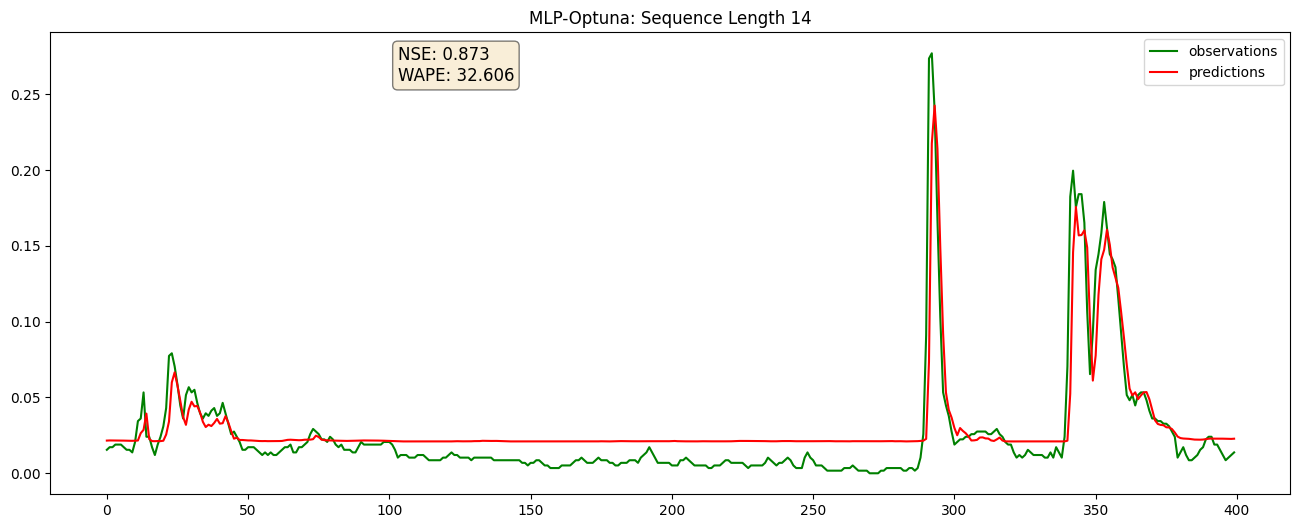

(tensor(0.0003), np.float32(0.8726548), np.float64(32.60580929130091))

In [31]:
evaluate_model(model, test_loader, True)